# TP Cuda - October 2022
## Part 1 : Pi
### Compilation realise par HABIB Danial et CHAHINE Maroun

Avant de lancer cette cellule se connecter sur une machine du departement avec GPU CUDA par exemple if501-219-12 en lançant la commande "ssh login@if501-219-12" puis lancer la commande "make part1"

### Performance evaluation

In [1]:
import os
import subprocess
import re

try:
    os.remove("stats.csv")
except OSError:
    pass

num_steps = [1000, 1000000]#, 100000000, 10000000000, 1000000000000]
nb_core = [1, 2, 4, 8, 16, 32, 64]
repeats = range(0,10)
executables = ['pi_sequential', 'pi_cuda_gpu', 'pi_cuda_shared_memory', 'pi_cuda_2_level_reduction', 'pi_multistage_reduction', 'pi_cuda_gpu_tableau', 'pi_cuda_tableau_2_level_reduction']

for nsteps in num_steps:
    for repeat in repeats:
        for executable in executables:
            args = ("./exe_bin/tp_cuda_part_1_" + executable, "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            try:
                out, err = popen.communicate(timeout=1)
            except Exception:
                out = b''
            if isinstance(out, bytes):
                out = out.decode(errors='ignore')

            # Extract pi value and time from output
            m = re.search(r'pi with\s+(\d+)\s+steps is\s+([0-9.+-eE]+)\s+in\s+([0-9.+-eE]+)\s+seconds', out)
            if m:
                pi_val = m.group(2)
                time_s = m.group(3)
            else:
                # fallback: use last non-empty line of stdout
                lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
                last = lines[-1] if lines else ''
                pi_val = ''
                time_s = ''
                # try to extract numbers from last line if possible
                m2 = re.search(r'([0-9.+-eE]+).*in.*([0-9.+-eE]+)\s*seconds', last)
                if m2:
                    pi_val = m2.group(1)
                    time_s = m2.group(2)
                else:
                    print(f"Warning: Could not extract pi and time from output for executable={executable}, nsteps={nsteps}. Output was:\n{out}")

            # one-line summary
            # print(f"{executable} | cores={ncore} | steps={nsteps} | repeat={repeat} | rc={popen.returncode} | pi={pi_val} | time_s={time_s}")
            csv_path = './Part_1/stats.csv'
            with open(csv_path, 'a') as fh:
                fh.write(f"{executable},{nsteps},{time_s}\n")



  User num_steps is 1000
CUDA driver version is insufficient for CUDA runtime version in Part_1/tp_cuda_part_1_pi_cuda_gpu.cu at line 44

  User num_steps is 1000
CUDA driver version is insufficient for CUDA runtime version in Part_1/tp_cuda_part_1_pi_cuda_shared_memory.cu at line 61

  User num_steps is 1000
CUDA driver version is insufficient for CUDA runtime version in Part_1/tp_cuda_part_1_pi_cuda_2_level_reduction.cu at line 48

  User num_steps is 1000
CUDA driver version is insufficient for CUDA runtime version in Part_1/tp_cuda_part_1_pi_multistage_reduction.cu at line 74

  User num_steps is 1000
CUDA driver version is insufficient for CUDA runtime version in Part_1/tp_cuda_part_1_pi_cuda_gpu_tableau.cu at line 43

  User num_steps is 1000
CUDA driver version is insufficient for CUDA runtime version in Part_1/tp_cuda_part_1_pi_cuda_tableau_2_level_reduction.cu at line 33

  User num_steps is 1000
CUDA driver version is insufficient for CUDA runtime version in Part_1/tp_cuda_pa

### Performance analysis
#### Weak scaling

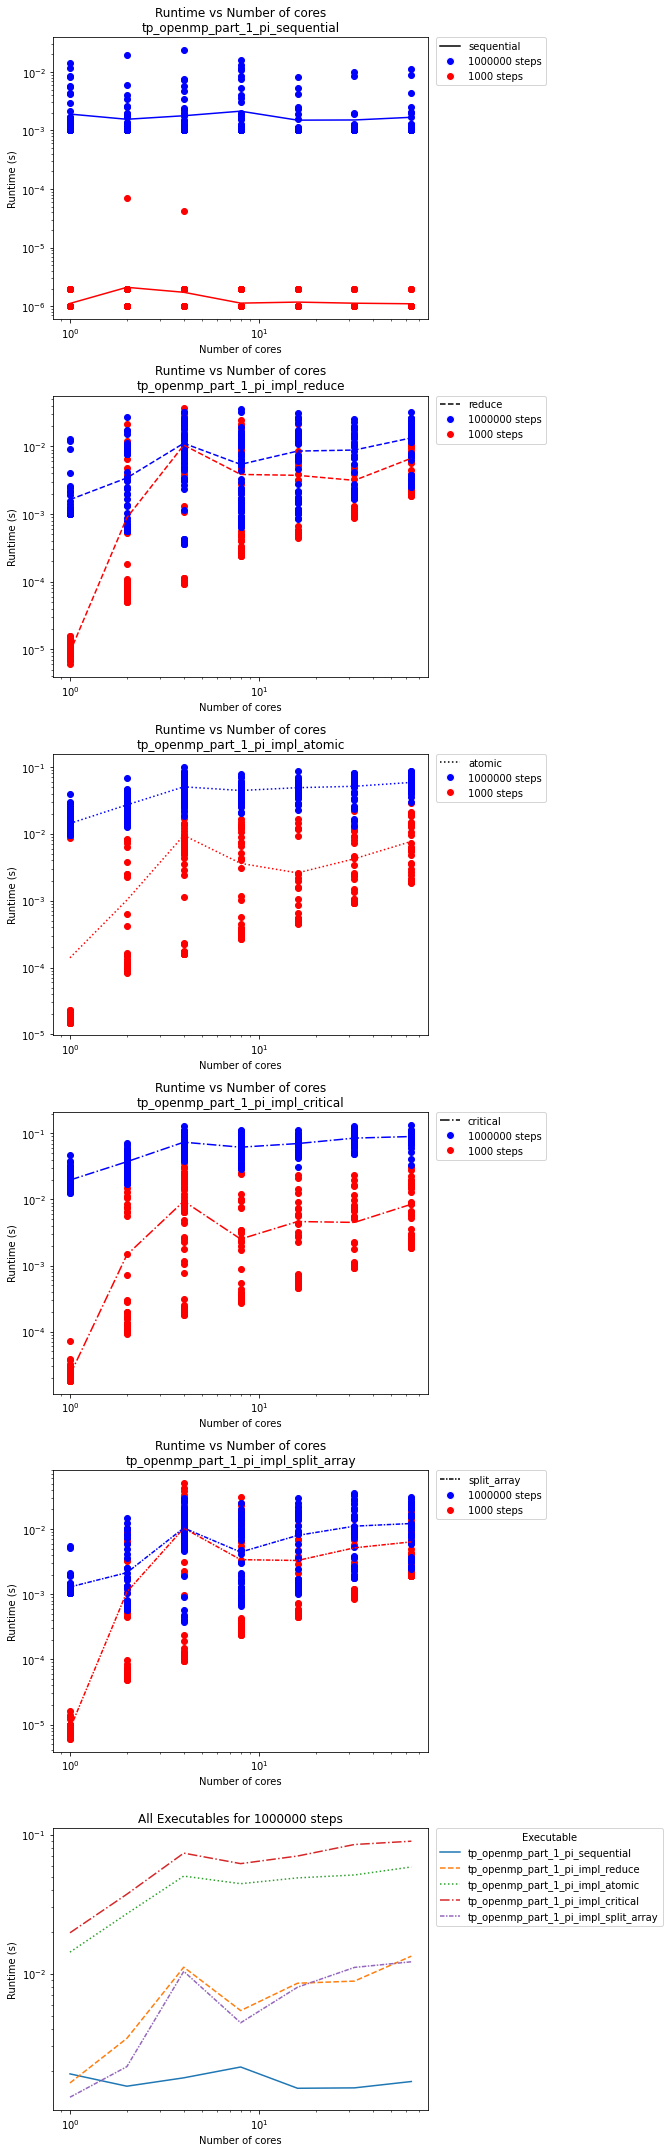

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Lecture du fichier CSV
df = pd.read_csv('./Part_1/stats.csv', header=None, names=['version','num_steps','runtime'], dtype={
                     'version': str,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {1000000 : "blue", 1000 : "red"}

# Nombre de subplots à créer : un pour chaque exécutable, cette fois disposés verticalement
fig, axes = plt.subplots(nrows=len(executables) + 1, ncols=1, figsize=(8, 5 * (len(executables) + 1)))

# Si il n'y a qu'un seul subplot (si executables ne contient qu'un seul élément)
if len(executables) == 1:
    axes = [axes]

# Style des lignes pour les différents exécutables
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1))]  # fallback styles pour jusqu'à 5 exécutables

# Tracer les courbes pour chaque exécutable dans son subplot respectif
for idx, executable in enumerate(executables):
    ax = axes[idx]  # Sélectionner le subplot correspondant à l'exécutable
    for num_steps in sorted(df['num_steps'].unique()):
        df_plot = df[(df['num_steps'] == int(num_steps)) & (df['version'] == executable)]
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['num_steps', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[idx] if idx < len(linestyles) else 'solid'
        ax.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, color=color_num_steps[int(num_steps)])
        ax.scatter(df_plot['nbcore'], df_plot['runtime'], color=color_num_steps[int(num_steps)])

    # Définir l'échelle des axes et les labels pour chaque subplot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime vs Number of cores\n{executable}')

    # Ajouter des légendes spécifiques pour cet exécutable
    num_steps_patches = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=f'{n} steps')
        for n, color in color_num_steps.items()
    ]
    version_handles = [
        plt.Line2D([0], [0], linestyle=ls, color='black', label=executable.replace('tp_openmp_part_1_pi_impl_', '').replace('tp_openmp_part_1_pi_', ''))
    ]

    ax.legend(handles=version_handles + num_steps_patches, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Ajouter un graphe avec tous les exécutables pour num_steps=1000000
ax_all_executables = axes[-1]  # Le dernier subplot

for executable in executables:
    df_plot = df[(df['num_steps'] == 1000000) & (df['version'] == executable)]
    if df_plot.empty:
        continue
    mean_stats = df_plot.groupby(['num_steps', 'version', 'nbcore']).mean().reset_index()
    ls = linestyles[executables.index(executable)] if executables.index(executable) < len(linestyles) else 'solid'
    ax_all_executables.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, label=executable)

# Définir l'échelle des axes et les labels pour le graphique global
ax_all_executables.set_xscale('log')
ax_all_executables.set_yscale('log')
ax_all_executables.set_xlabel('Number of cores')
ax_all_executables.set_ylabel('Runtime (s)')
ax_all_executables.set_title('All Executables for 1000000 steps')

# Ajouter une légende pour le graphique global
ax_all_executables.legend(title='Executable', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Ajuster l'agencement des subplots
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


### Discussion

## Part 2 : Matrix-Vector Operation
### Compilation


Avant de lancer cette cellule se connecter sur une machine du departement avec GPU CUDA par exemple if501-219-12 en lançant la commande "ssh login@if501-219-12" puis lancer la commande "make part2"

### Performance evaluation

In [31]:
import os
import subprocess
import re

try:
    os.remove("stats.csv")
except OSError:
    pass

N = [2, 4]#, 8, 10, 12, 14, 16]
M = [1, 3]#, 7, 9, 11, 13, 15]
nb_core = [1, 2, 4, 8, 16, 32, 64]
repeats = range(0,20)
executables = ['tp_openmp_part_2_vector_openmp', 'tp_openmp_part_2_vector_sequential', 'tp_openmp_part_2_vector_simd']

for n in N:
    for m in M:
        for ncore in nb_core:
            for repeat in repeats:
                for executable in executables:
                    args = ("./exe_bin/" + executable, "-T", str(ncore), "-N", str(n), "-M", str(m))
                    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                    popen.wait()

                    try:
                        out, err = popen.communicate(timeout=1)
                    except Exception:
                        out = b''
                    if isinstance(out, bytes):
                        out = out.decode(errors='ignore')

                    # extraire uniquement le temps (en secondes) depuis la sortie
                    lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
                    last = lines[-1] if lines else ''
                    time_s = ''

                    # priorité 1: time(...) présent dans la sortie
                    m_time = re.search(r'time\(\s*([0-9.+-eE]+)\s*s', out, flags=re.IGNORECASE)
                    if m_time:
                        time_s = m_time.group(1)
                    else:
                        # fallback 1: "in X seconds"
                        m_time2 = re.search(r'in\s+([0-9.+-eE]+)\s+seconds', out, flags=re.IGNORECASE)
                        if m_time2:
                            time_s = m_time2.group(1)
                        else:
                            # fallback final: dernier nombre flottant sur la dernière ligne non vide
                            m3 = re.findall(r'([0-9.+-eE]+)', last)
                            time_s = m3[-1] if m3 else ''

                    # one-line summary
                    # print(f"{executable} | cores={ncore} | steps={nsteps} | repeat={repeat} | rc={popen.returncode} | pi={pi_val} | time_s={time_s}")
                    csv_path = './Part_2/stats.csv'
                    with open(csv_path, 'a') as fh:
                        fh.write(f"{executable},{ncore},{n},{m},{time_s}\n")



FileNotFoundError: [Errno 2] No such file or directory: './exe_bin/tp_openmp_part_2_vector_openmp'

### Performance analysis
#### Weak scaling

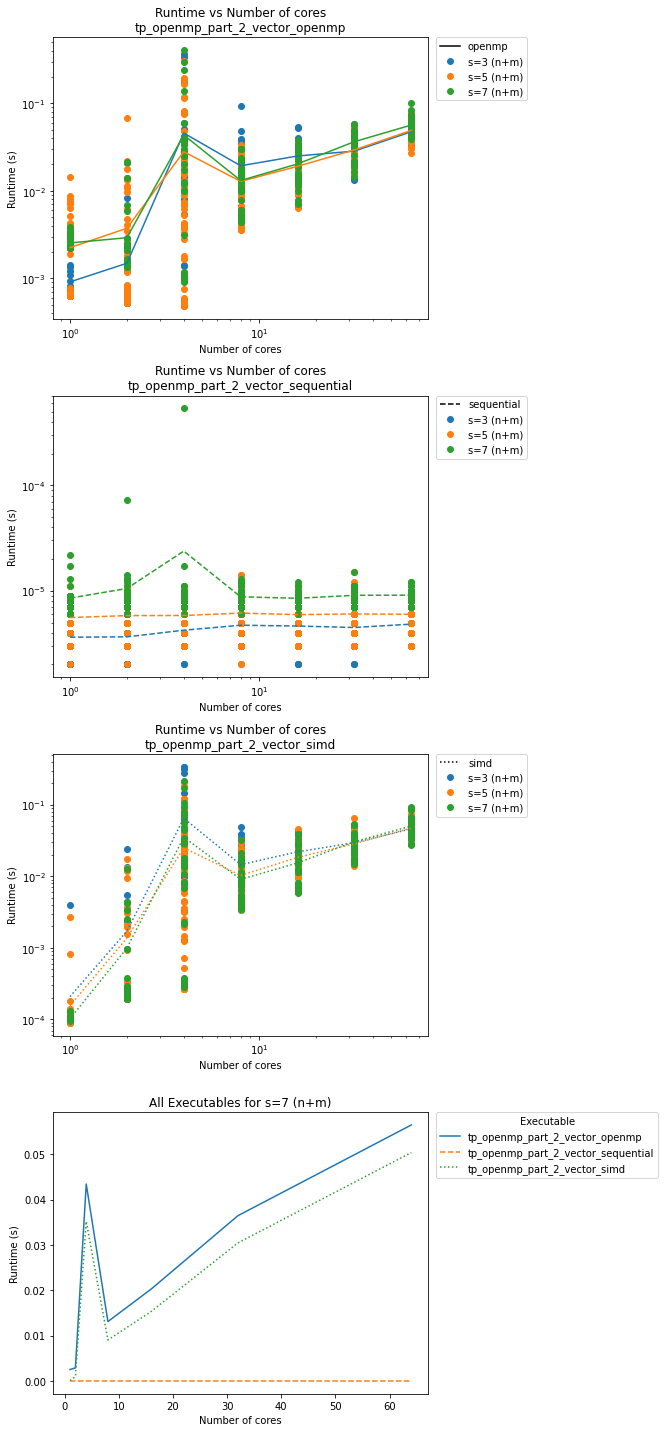

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Lecture du fichier CSV Part 2 (format: executable,ncore,n,m,runtime)
df = pd.read_csv('./Part_2/stats.csv', header=None,
                 names=['version','nbcore','n','m','runtime'],
                 dtype={'version': str, 'nbcore': int, 'n': int, 'm': int, 'runtime': float})

# nouvelle colonne s = n + m
df['s'] = df['n'] + df['m']

# mapping de couleurs pour chaque valeur de s
unique_s = sorted(df['s'].unique())
cmap = plt.get_cmap('tab10')
colors_s = {s: cmap(i % cmap.N) for i, s in enumerate(unique_s)}

# subplots : un par exécutable + un dernier récapitulatif
fig, axes = plt.subplots(nrows=len(executables) + 1, ncols=1, figsize=(8, 5 * (len(executables) + 1)))
if len(executables) == 1:
    axes = [axes]

linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1))]

for idx, executable in enumerate(executables):
    ax = axes[idx]
    for s in unique_s:
        df_plot = df[(df['s'] == s) & (df['version'] == executable)]
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['s', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[idx] if idx < len(linestyles) else 'solid'
        ax.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, color=colors_s[s])
        ax.scatter(df_plot['nbcore'], df_plot['runtime'], color=colors_s[s])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime vs Number of cores\n{executable}')

    # légende par valeur de s
    s_patches = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_s[s], markersize=8, label=f's={s} (n+m)')
        for s in unique_s
    ]
    version_handle = plt.Line2D([0], [0], linestyle=ls, color='black',
                                label=executable.replace('tp_openmp_part_2_vector_', ''))
    ax.legend(handles=[version_handle] + s_patches, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# dernier subplot : tracer tous les exécutables pour une valeur de s choisie (ici la plus grande s)
ax_all_executables = axes[-1]
s_to_plot = unique_s[-1] if unique_s else None

if s_to_plot is not None:
    for executable in executables:
        df_plot = df[(df['s'] == s_to_plot) & (df['version'] == executable)]
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['s', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[executables.index(executable)] if executables.index(executable) < len(linestyles) else 'solid'
        ax_all_executables.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, label=executable)

    #ax_all_executables.set_xscale('log')
    #ax_all_executables.set_yscale('log')
    ax_all_executables.set_xlabel('Number of cores')
    ax_all_executables.set_ylabel('Runtime (s)')
    ax_all_executables.set_title(f'All Executables for s={s_to_plot} (n+m)')
    ax_all_executables.legend(title='Executable', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


### Discussion

## Part 3 : Matrix Multiplication
### Compilation

Avant de lancer cette cellule se connecter sur une machine du departement avec GPU CUDA par exemple if501-219-12 en lançant la commande "ssh login@if501-219-12" puis lancer la commande "make part3"

### Performance evaluation

In [7]:
import os
import subprocess
import re

try:
    os.remove("stats.csv")
except OSError:
    pass

N = [1000, 2000]#, 3000, 4000, 5000, 6000, 7000]
M = [1000, 2000]#, 3000, 4000, 5000, 6000, 7000]
nb_core = [1, 2, 4]#, 8, 16, 32, 64]
repeats = range(0,3)
executables = ['tp_open_part_4_matrix_mult_sequential', 'tp_open_part_4_matrix_mult_openmp', 'tp_open_part_4_matrix_mult_openmp_half', 'tp_open_part_4_matrix_mult_openmp_float']

for n in N:
    for m in M:
        for ncore in nb_core:
            for repeat in repeats:
                for executable in executables:
                    args = ("./exe_bin/" + executable, "-T", str(ncore), "-N", str(n), "-M", str(m))
                    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                    popen.wait()

                    try:
                        out, err = popen.communicate(timeout=1)
                    except Exception:
                        out = b''
                    if isinstance(out, bytes):
                        out = out.decode(errors='ignore')

                    # extraire uniquement le temps (en secondes) depuis la sortie
                    lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
                    last = lines[-1] if lines else ''
                    time_s = ''

                    # priorité 1: time(...) présent dans la sortie
                    m_time = re.search(r'time\(\s*([0-9.+-eE]+)\s*s', out, flags=re.IGNORECASE)
                    if m_time:
                        time_s = m_time.group(1)
                    else:
                        # fallback 1: "in X seconds"
                        m_time2 = re.search(r'in\s+([0-9.+-eE]+)\s+seconds', out, flags=re.IGNORECASE)
                        if m_time2:
                            time_s = m_time2.group(1)
                        else:
                            # fallback final: dernier nombre flottant sur la dernière ligne non vide
                            m3 = re.findall(r'([0-9.+-eE]+)', last)
                            time_s = m3[-1] if m3 else ''

                    # one-line summary
                    # print(f"{executable} | cores={ncore} | steps={nsteps} | repeat={repeat} | rc={popen.returncode} | pi={pi_val} | time_s={time_s}")
                    csv_path = './Part_4/stats.csv'
                    with open(csv_path, 'a') as fh:
                        fh.write(f"{executable},{ncore},{n},{m},{time_s}\n")



### Performance analysis
#### Weak scaling

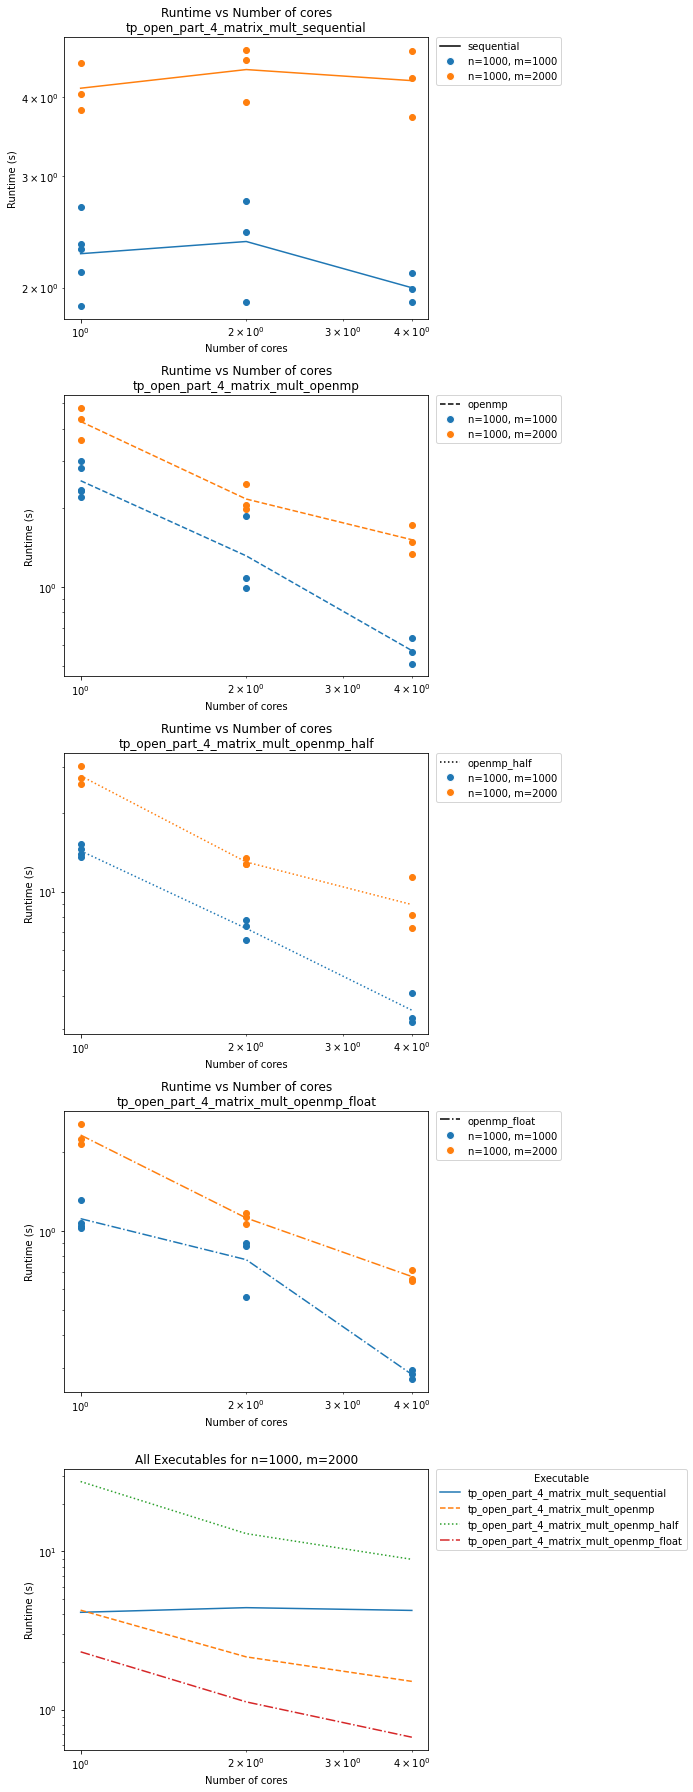

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Lecture du fichier CSV Part 4 (format: executable,ncore,n,m,runtime)
df = pd.read_csv('./Part_4/stats.csv', header=None,
                 names=['version', 'nbcore', 'n', 'm', 'runtime'],
                 dtype={'version': str, 'nbcore': int, 'n': int, 'm': int, 'runtime': float})

df.dropna(subset=['runtime'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Création de la colonne nm pour le couple (n, m)
df['nm'] = list(zip(df['n'], df['m']))

# Mapping de couleurs pour chaque couple (n, m)
unique_nm = sorted(df['nm'].unique())  # Utiliser (n, m) au lieu de 'n' seul
cmap = plt.get_cmap('tab10')
colors_nm = {nm: cmap(i % cmap.N) for i, nm in enumerate(unique_nm)}

# Subplots : un par exécutable + un dernier récapitulatif
fig, axes = plt.subplots(nrows=len(executables) + 1, ncols=1, figsize=(8, 5 * (len(executables) + 1)))
if len(executables) == 1:
    axes = [axes]

# Styles de ligne pour chaque exécutable
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1))]

# Tracer chaque exécutable
for idx, executable in enumerate(executables):
    ax = axes[idx]
    for nm in unique_nm:  # Filtrer par couple (n, m)
        df_plot = df[(df['nm'] == nm) & (df['version'] == executable)]  # Filtrer par (n, m) et 'version'
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['nm', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[idx] if idx < len(linestyles) else 'solid'
        ax.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, color=colors_nm[nm])
        ax.scatter(df_plot['nbcore'], df_plot['runtime'], color=colors_nm[nm])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime vs Number of cores\n{executable}')

    # Légende par couple (n, m)
    nm_patches = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_nm[nm], markersize=8, label=f'n={nm[0]}, m={nm[1]}')
        for nm in unique_nm
    ]
    version_handle = plt.Line2D([0], [0], linestyle=ls, color='black',
                                label=executable.replace('tp_open_part_4_matrix_mult_', ''))
    ax.legend(handles=[version_handle] + nm_patches, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Dernier subplot : tracer tous les exécutables pour un couple (n, m) choisi (ici le dernier couple (n, m))
ax_all_executables = axes[-1]
nm_to_plot = unique_nm[-1] if unique_nm else None

if nm_to_plot is not None:
    for executable in executables:
        df_plot = df[(df['nm'] == nm_to_plot) & (df['version'] == executable)]  # Filtrer par (n, m)
        if df_plot.empty:
            continue
        mean_stats = df_plot.groupby(['nm', 'version', 'nbcore']).mean().reset_index()
        ls = linestyles[executables.index(executable)] if executables.index(executable) < len(linestyles) else 'solid'
        ax_all_executables.plot(mean_stats['nbcore'], mean_stats['runtime'], linestyle=ls, label=executable)

    ax_all_executables.set_xscale('log')
    ax_all_executables.set_yscale('log')
    ax_all_executables.set_xlabel('Number of cores')
    ax_all_executables.set_ylabel('Runtime (s)')
    ax_all_executables.set_title(f'All Executables for n={nm_to_plot[0]}, m={nm_to_plot[1]}')
    ax_all_executables.legend(title='Executable', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Ajuster l'agencement des subplots
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


### Discussion